In [1]:
import numpy as np
import pyNNGP
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

%matplotlib inline

## 2d Example
We consider a function on two inputs given by 
$$
f(x, y) = \sin(5xy) + \sin \left (5 \frac{x}{y} \right).
$$
We uniformly sample 3000 pairs of coordinates on $[0, 1]^2$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ noise.

In [2]:
import numpy as np
import pyNNGP

n = 3000
nstar = 30
m = 3
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 2))
s = np.argsort(coords[:,0])
coords = coords[s]

def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w = f(coords[:, 0], coords[:, 1])
noise = np.random.normal(0, 0.25, size=n)
y = w + noise

covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=m,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
for i in range(20):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))

w_map = nngp.predict(coords.T)
w_map = w_map.reshape((n))

newcoords = np.random.uniform(0, 1, size=(nstar, 2))
s = np.argsort(newcoords[:,0])
newcoords = newcoords[s]

# distMat = np.array([[np.linalg.norm(coords[x, :] - coords[y, :]) for x in range(n)] for y in range(n)])
# covMat = np.array([[nngp.covModel.cov(distMat[x, y]) for x in range(n)] for y in range(n)]) + 0.5 * np.eye(n)
# invCovMat = np.linalg.inv(covMat)
# crossdist = np.array([[np.linalg.norm(coords[y, :] - newcoords[x,:]) for y in range(n)] for x in range(nstar)])
# crosscov = np.array([[nngp.covModel.cov(crossdist[x, y]) for y in range(n)] for x in range(nstar)])

def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w_new = f(newcoords[:, 0], newcoords[:, 1])
w_new_map = nngp.predict(newcoords.T)
w_new_map = w_new_map.reshape((nstar))

Let's plot the resulting surface

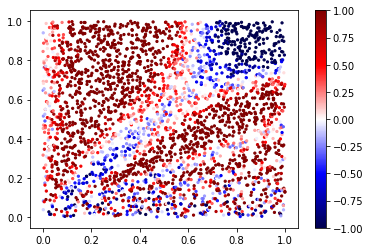

In [3]:
plt.scatter(
    coords[:,0], coords[:,1],
    c=y, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar()
plt.show()

We will train an NNGP to model this surface. We specify the model below, using the squared exponential kernel and conditioning the likelihood of each training observation on at most 3 others.

In [4]:
# covModel = pyNNGP.SqExp(
#     sigmaSq=0.5, 
#     phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
#     sigmaSqIGa=0.04, sigmaSqIGb=0.04
# )

# noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

# distFunc = pyNNGP.Euclidean()

# nngp = pyNNGP.SeqNNGP(
#     y, coords,
#     nNeighbors=m,
#     covModel=covModel,
#     distFunc=distFunc,
#     noiseModel=noiseModel
# )

In [5]:
# w_samples = []
# for i in range(30):
#     nngp.sample(10)
#     w_samples.append(np.copy(nngp.w))

In [6]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

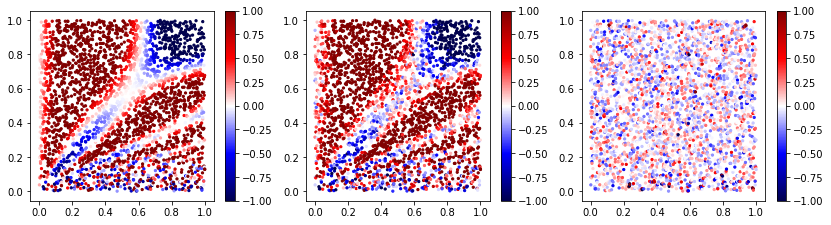

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
i0 = axes[0].scatter(
    coords[:,0], coords[:,1], 
    c=w, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i0, ax=axes[0])
i1 = axes[1].scatter(
    coords[:,0], coords[:,1],
    c=w_map, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i1, ax=axes[1])
i2 = axes[2].scatter(
    coords[:,0], coords[:,1],
    c=w_map-w, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar(i2, ax=axes[2])
plt.show()

Now we will normalize the coordinates to project onto the unit circle.

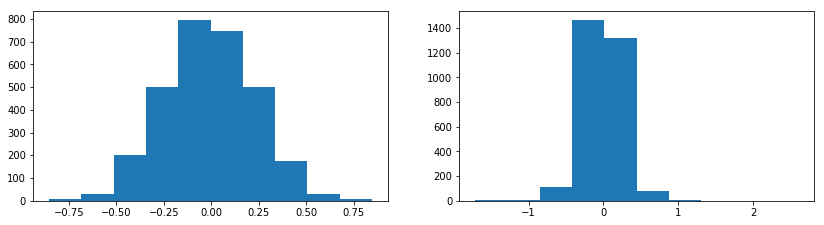

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 3.5))
i0 = axes[0].hist(w_samples[-1] - w)    
i1 = axes[1].hist(w_map - w)
plt.show()

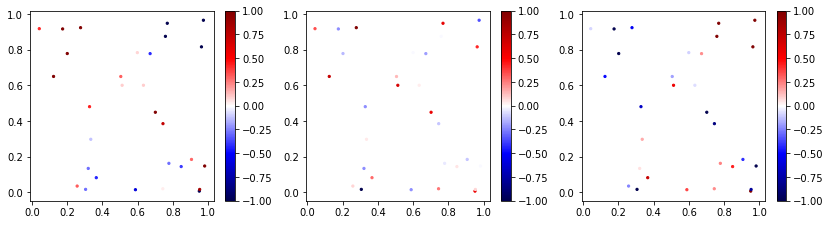

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
i0 = axes[0].scatter(
    newcoords[:,0], newcoords[:,1], 
    c=w_new, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i0, ax=axes[0])
i1 = axes[1].scatter(
    newcoords[:,0], newcoords[:,1],
    c=w_new_map, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)    
plt.colorbar(i1, ax=axes[1])
i2 = axes[2].scatter(
    newcoords[:,0], newcoords[:,1],
    c=w_new_map-w_new, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar(i2, ax=axes[2])
plt.show()

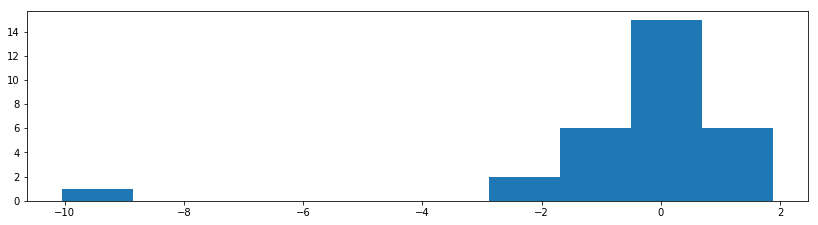

In [10]:
fig, axes = plt.subplots(ncols=1, figsize=(14, 3.5))
i0 = axes.hist(w_new_map - w_new)    
plt.show()

In [11]:
w_new_map

array([ 3.43889253e-01,  7.24424414e-01, -2.19530412e-01, -1.40312093e-01,
        8.24135434e-02,  1.42859699e+00, -1.03225595e+01, -2.25660610e-01,
       -2.23998823e-01,  4.66462806e-02,  2.90295749e-01,  1.33283382e-01,
        6.62711273e-01, -2.25068428e-01, -7.90903862e-03,  3.25277043e-02,
       -1.91655011e-01,  5.84192508e-01,  2.69802077e-01, -1.13559867e-01,
       -9.49740743e-03,  5.99443265e-01, -4.12240429e-02,  5.17929817e-02,
       -1.10732071e-01,  5.70993467e-01,  8.15134277e-02,  4.33442917e-01,
       -3.51259508e-01, -1.36537115e-02])

In [12]:
w_new

array([ 0.42558975,  1.20528411,  1.53572727,  1.66831355,  0.32379981,
        1.95525394, -0.28391421, -0.28350947,  0.43968787, -0.12195556,
       -0.43444473,  0.31939284,  0.09631188, -0.59595164,  0.08535331,
        0.09976235, -0.41708337,  1.99909615,  0.03675467,  0.74104747,
       -1.10491885, -1.27386374, -0.28426141, -0.38809673,  0.29890292,
       -0.96984814,  0.85673886, -1.08684129, -1.94685745,  1.55281955])